# Loading ANL Cluster Lensing Simulations into CLMM
Authors: **Celine Combet, Matthew Ho, Joe Hollowed**

This tutorial describes how to load in ANL Cluster Lensing maps into the CLMM pipeline to generate shear profiles and make mass predictions. This acts as an extension to the ANL simulations data access tutorial.


### ANL Cluster Lensing
* **data**: /global/homes/h/hollowed/desc_CLxCS_2019/data/
* **tutorial**: /global/homes/h/hollowed/desc_CLxCS_2019/cl_demo.ipynb

### CLMM
* **repo**: https://github.com/LSSTDESC/CLMM

### TODO:
* Extend analysis to ANL sims with numerous source planes
* Fit shear profiles with CCL halo profile tools

In [3]:
# first equip our weapons
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
def step2z(step): return np.linspace(1/(200_1), 1, 500)[step]
def safeLog10(x, minval=1e-7): return np.log(x.clip(min=minval))

# point to the data
data_path = '/global/homes/h/hollowed/desc_CLxCS_2019/data'

## Load and visualize ANL maps

The grid maps are written with each hdf5 group representing one lens plane. In the various X.gmaps.hdf5 files, there will be one group per lens plane, corresponding to the redshift bounds of a shell of the base particle lightcone, and named after the corresponding HACC simulation timestep. If you need to convert those timestep values to redshift, call the `step2z()` lambda function provided above

In [36]:
# randomly choose one of the 9 halos provided in the preliminary dataset to read
# (change idx if you want something constant, this is just for convenience)

#halos_available = np.array([s.split('/')[-1] for s in glob.glob('./data/*')])
halos_available = np.array([s.split('/')[-1] for s in glob.glob(data_path+'/*')])
idx = int(np.random.rand(1)*len(halos_available))
halo_id = halos_available[idx]

prop_file = '{0}/{1}/properties.csv'.format(data_path, halo_id)
gmaps_file = '{0}/{1}/{1}_10.0_gmaps.hdf5'.format(data_path, halo_id)
raytrace_file = glob.glob('{0}/{1}/{1}_*_raytraced_maps.hdf5'.format(data_path, halo_id))[0]
halo_properties = np.genfromtxt(prop_file, delimiter=',')

print('\n---- Working on halo {} ----'.format(halo_id))
print('---- With mass M = {:.2e} Msun ----'.format(halo_properties[2]))
print('---- Located at redshift z = {} ----'.format(halo_properties[0]))


---- Working on halo halo_4774174546982633472_0 ----
---- With mass M = 9.32e+14 ----
---- Located at redshift z = 0.348958 ----


In [33]:
halo_properties

array([  4.75493000e-01,   3.31000000e+02,   9.11285000e+14,
         1.99210000e+00,   4.23717000e+02,   6.89994000e+02,
         9.92180000e+02,   4.65653000e+00,   7.50000000e+02])

In [5]:
# read the ray traced file for the source redshift

halo_raytrace = h5py.File(raytrace_file, 'r')
source_z = list(halo_raytrace.keys())[0] 
print('source plane at z = ',list(halo_raytrace.keys()))
g1 = halo_raytrace[source_z]['shear1'].value
g2 = halo_raytrace[source_z]['shear2'].value
kf0 = halo_raytrace[source_z]['kappa0'].value
logk = safeLog10(kf0.T)

source plane at z =  ['zs_1.4866']


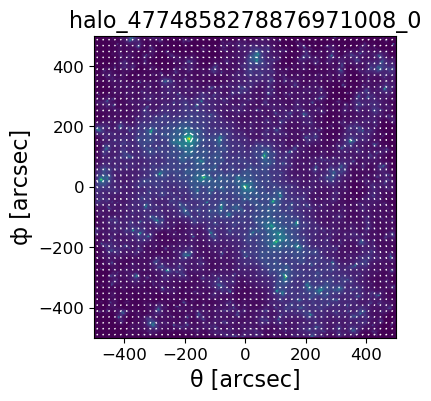

In [6]:
# visualize the convergence and shear...

# get scale of FOV and define grid
nnx, nny = np.shape(logk)
boxsize_arcsec = float(halo_properties[8])
ds = boxsize_arcsec/nnx
x1 = np.linspace(0,boxsize_arcsec-ds,nnx)-boxsize_arcsec/2.0+ds/2.0
x2 = np.linspace(0,boxsize_arcsec-ds,nnx)-boxsize_arcsec/2.0+ds/2.0
x2,x1 = np.meshgrid(x1,x2)

# define figure, plot convergence on color axis
plt.figure(figsize=(4, 4), dpi=100)
plt.imshow(logk,aspect='equal',cmap=plt.cm.viridis,origin='higher',
           extent=[-boxsize_arcsec/2.0,
                    boxsize_arcsec/2.0,
                   -boxsize_arcsec/2.0,
                    boxsize_arcsec/2.0,], 
                    vmin=np.percentile(logk, 5))

# plot shear vector field
grid_spacing = 20
scale_shear = 180

for i in range(int(grid_spacing/2),nnx,grid_spacing):
    for j in range(int(grid_spacing/2),nny,grid_spacing):
        gt1 = g1[i, j]
        gt2 = g2[i, j]
        ampli = np.sqrt(gt1*gt1+gt2*gt2)
        alph = np.arctan2(gt2,gt1)/2.0

        st_x = x1[i, j]-ampli*np.cos(alph)*scale_shear
        ed_x = x1[i, j]+ampli*np.cos(alph)*scale_shear

        st_y = x2[i, j]-ampli*np.sin(alph)*scale_shear
        ed_y = x2[i, j]+ampli*np.sin(alph)*scale_shear

        plt.plot([st_x,ed_x],[st_y,ed_y],'w-',linewidth=1.0)

plt.xlim(-boxsize_arcsec/2.0, boxsize_arcsec/2.0)
plt.ylim(-boxsize_arcsec/2.0, boxsize_arcsec/2.0)
plt.xlabel('θ [arcsec]', fontsize=16)
plt.ylabel('ф [arcsec]', fontsize=16)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.title(halo_id, fontsize=16)

plt.show()

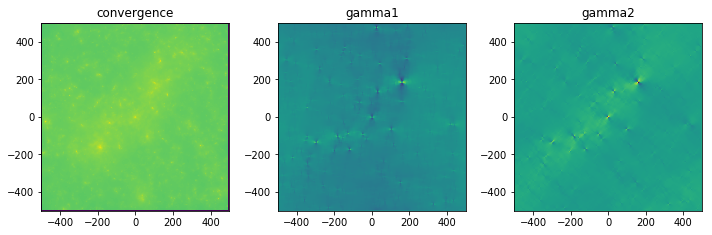

In [7]:
# Visualize convergence and shear maps

f, axes = plt.subplots(1, 3, figsize=(10,10))

axes[0].imshow(logk, aspect='equal',
               extent=[-boxsize_arcsec/2.0,
                        boxsize_arcsec/2.0,
                       -boxsize_arcsec/2.0,
                        boxsize_arcsec/2.0,])
axes[0].set_title('convergence')

axes[1].imshow(g1, aspect='equal',
               extent=[-boxsize_arcsec/2.0,
                        boxsize_arcsec/2.0,
                       -boxsize_arcsec/2.0,
                        boxsize_arcsec/2.0,])
axes[1].set_title('gamma1')

axes[2].imshow(g2, aspect='equal',
               extent=[-boxsize_arcsec/2.0,
                        boxsize_arcsec/2.0,
                       -boxsize_arcsec/2.0,
                        boxsize_arcsec/2.0,])
axes[2].set_title('gamma2')

f.tight_layout()

## Populating shear maps with galaxies

In [11]:
# Randomly choose pixels to serve as 'galaxies' according to an area density of 
# galaxies per square arcmin

nperarcmin = 50 # galaxy density (in galaxies per arcmin**2)

ra_0, dec_0 = 0,0 # observation center (in arcsec)

side_length = halo_properties[8] # survey side length (in arcsec)

redshift = float(list(halo_raytrace.keys())[0][3:]) # redshift of source plane
print('Source plane at z = {}'.format(redshift))

Source plane at z = 1.4866


In [9]:
# ~~~ Choosing random pixels to serve as galaxies

area = (side_length/60.)**2 # in arcmin**2
threshold = nperarcmin*area/(len(g1)**2) # num_gals/pixels

mask = np.random.rand(*g1.shape)<threshold # True values represent selected galaxy-pixels

print(np.sum(mask)) # number of galaxies

13722


## Generating applicable quantities (ra, dec, shear, convergence, z)

In [12]:
ra, dec = (np.indices(g1.shape)-g1.shape[0]/2)*side_length/len(g1) # in arcsec

# shift to origin position
ra += ra_0
dec += dec_0

# convert to degrees
ra /= 3600
dec /= 3600

num gal: 13722


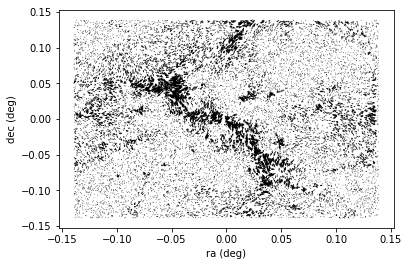

In [15]:
# plot galaxy shear

plt.quiver(ra[mask],dec[mask], g1[mask]/5, -g2[mask]/5)

plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

print('num gal:',np.sum(mask))

## Import galaxy quantities into CLMM

In [16]:
from clmm import datatypes
from clmm import ShearAzimuthalAverager
from astropy.table import Table

In [17]:
# cluster dictionary
cl_dict = {'z':halo_properties[0], 'ra':ra_0, 'dec': dec_0}

In [18]:
# source table
# We need a -g2 as the convention on the ANL maps is not the same as in CLMM
t = Table([np.arange(np.sum(mask)),ra[mask], dec[mask], g1[mask],-g2[mask],\
           [redshift]*np.sum(mask),kf0[mask]],\
           names=('id','ra','dec', 'gamma1', 'gamma2', 'z', 'kappa'))

In [19]:
t_clmm = datatypes.GCData('source catalog', {}, t)
t_clmm

GCData(creator='source catalog', specs={}, values=<Table length=13722>
  id        ra            dec         gamma1  gamma2    z     kappa 
int64    float64        float64      float32 float32 float64 float32
----- ------------- ---------------- ------- ------- ------- -------
    0   -0.13888875 -0.0425889331055     0.0    -0.0  1.4866     0.0
    1   -0.13888875 -0.0143771557617     0.0    -0.0  1.4866     0.0
    2   -0.13888875  0.0176323608398     0.0    -0.0  1.4866     0.0
    3   -0.13888875   0.039876262207     0.0    -0.0  1.4866     0.0
    4   -0.13888875  0.0439452685547     0.0    -0.0  1.4866     0.0
    5   -0.13888875  0.0726995800781     0.0    -0.0  1.4866     0.0
    6   -0.13888875  0.0764973193359     0.0    -0.0  1.4866     0.0
    7   -0.13888875   0.102538959961     0.0    -0.0  1.4866     0.0
    8   -0.13888875   0.105522897949     0.0    -0.0  1.4866     0.0
    9   -0.13888875   0.106336699219     0.0    -0.0  1.4866     0.0
  ...           ...             

In [20]:
saa = ShearAzimuthalAverager(cl_dict, t_clmm)

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/astropy/table/row.py:65: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


read g1, g2 directly


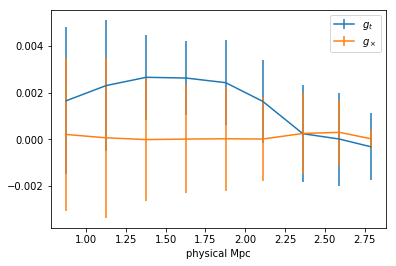

In [21]:
# compute tangential and cross shear for each galaxy
saa.compute_shear()

# make the binned profile
binned_profile = saa.make_shear_profile()

# signal!
saa.plot_profile()